# 1. Data Pre-processing
## 1.1 Importing and Checking Data
**Importing relevant libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Reading in the data**

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
print("Shape of training data is: ", train_df.shape) #(891, 12)
print("Shape of test data is: ", test_df.shape) #(418, 11)

Shape of training data is:  (891, 12)
Shape of test data is:  (418, 11)


**Checking for Duplicates in Training and Test Data**

In [3]:
print("Number of duplicates: ", train_df.duplicated().sum())
print("Number of duplicates: ", test_df.duplicated().sum())

Number of duplicates:  0
Number of duplicates:  0


**Checking if any columns are different or missing**

The only column that is different is "Survived", which is missing from the test data. This is expected as this is what we are trying to predict with the test data.

In [4]:
print("Missing columns are: ", set(train_df.columns).symmetric_difference(test_df.columns)) #OK

Missing columns are:  {'Survived'}


## 1.2 Summary Statistics
Examining the variables, their types and summary statistics
* Name, Sex, Ticket, Cabin and Embarked are non-numerical columns
* Age, Cabin, Fare and Embarked are columns with missing values

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


**Percentage of Passengers that Survived**

If we look at only the training data, 38% of passengers survived on the Titanic.

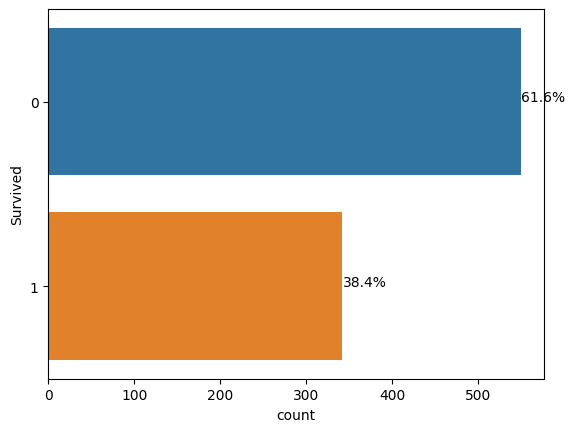

In [7]:
ax = sns.countplot(y = "Survived", data = train_df)
total = len(train_df["Survived"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

## 1.3 Imputation of Missing Values
Examining variables with null values and counting the total amount of nulls. 

Training data:
* 687 passengers do not have a cabin number
* 2 passengers have no embarked status
* 177 passengers do not have a recorded age


In [8]:
train_df.isna().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [9]:
test_df.isna().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

### 1.3.1 Imputation of Embarked 
There are just two missing values from the training data only. We will fill in the missing values with the port that passengers most frequently embarked on

In [10]:
train_df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [11]:
most_frequent = "S"
train_df["Embarked"].fillna("S", inplace = True)

In [12]:
#Confirming that there are no more null values
train_df["Embarked"].isnull().any()

False

### 1.3.2 Imputation of Age

Instead of assuming that all passengers that have no recorded age have the same mean age across the entire Titanic population, we will break down age into various segments.

Based on the other features, it is probable that age is based on factors such as Title (which can be derived from the name using regex expressions) and PClass.

**Age Segmented by Title**

Titles such as Master were primarily used for younger boys while Reverend, Countess and Major would be more relevant for older passengers. Other more common titles can imply a passenger's relative age (Miss/Ms vs Mrs).

Titles will be segmented by similarity such that average age can be derived by a passenger's title.

In [13]:
datasets = [train_df, test_df]
#Extracting title from name
pattern = '\s(\w+)\.' #This regex expression finds a sequence of letters with a white space, a sequence of letters and then a dot character
for data in datasets:
    data["Title"] = data["Name"].str.extract(pattern)

In [14]:
#Getting value counts of each title for the training data
for data in datasets:
    print(pd.concat([data["Title"].value_counts(),data["Title"].value_counts()]), "\n")

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64 

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64 



<Axes: xlabel='Title', ylabel='Age'>

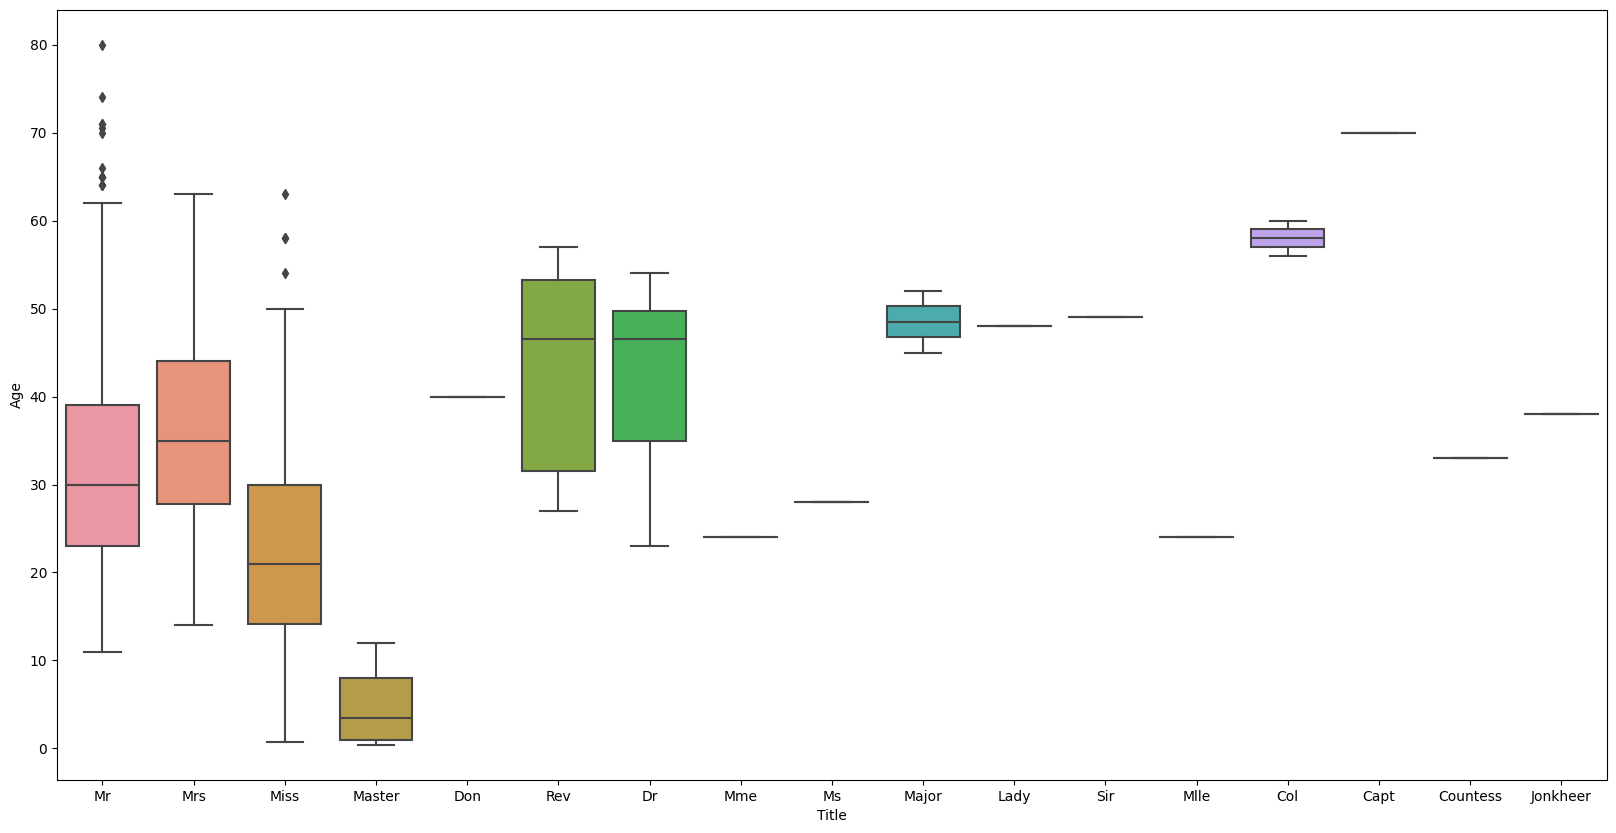

In [15]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x="Title", y="Age", data=train_df)

More common grouped titles include Mr, Mrs, Ms and Master (which refers to young boys/men).
Titles such as Reverend, Don, Lady all refer to royal or noble ranks so they will be grouped together as 'Noble'.
Other less common titles such as Reverend, Doctor and Captain will be grouped as 'Other'.

In [16]:
for data in datasets:
    data["Title"].replace(to_replace = ["Countess", "Sir", "Lady", "Don", "Dona", "Jonkheer"], value = "Noble", inplace = True)
    data["Title"].replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Other", inplace = True)
    data["Title"].replace(to_replace = "Mme", value = "Mrs", inplace = True)
    data["Title"].replace(to_replace = ["Mlle", "Miss"], value = "Ms", inplace = True)
    data["Title"].value_counts()

<Axes: xlabel='Title', ylabel='Age'>

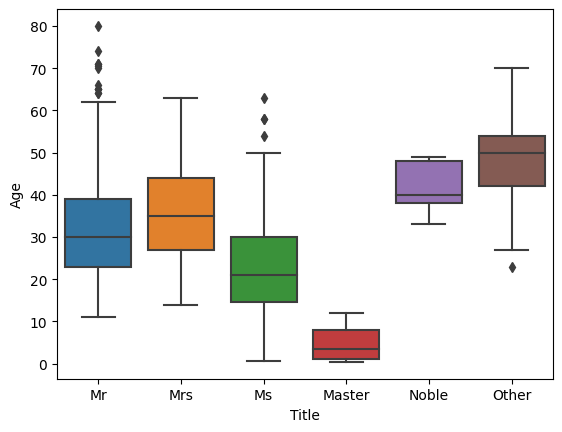

In [17]:
sns.boxplot(x="Title", y="Age", data=train_df)

**Age Segmented by PClass**

On average, passengers from first class are older than those of second class, who are older than those of third class.

<Axes: xlabel='Pclass', ylabel='Age'>

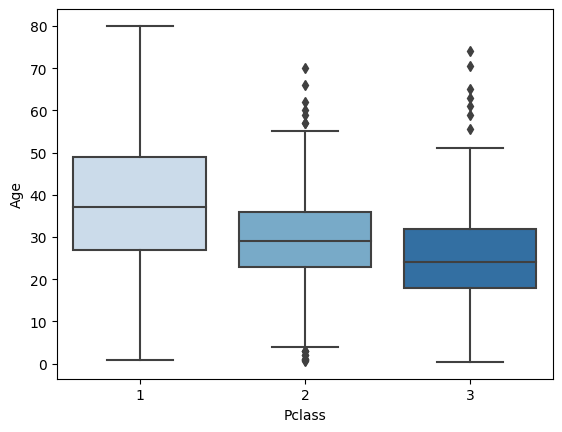

In [18]:
sns.boxplot(x="Pclass", y="Age", data=train_df, palette = "Blues")

**Age Segmented by Title and PClass**

Any missing ages for training and test data will be imputed with the average ages based on the passenger's Title and PClass derived from the training data only. This avoids data leakage from the test set.

In [19]:
data=train_df.groupby(["Title", "Pclass"]).agg(average_age = ("Age", "mean"), 
                                               min_age = ("Age", "min"), 
                                               max_age = ("Age", "max"),
                                               std_age = ("Age", "std"),
                                               count_passengers = ("PassengerId", "count"))

**Imputing Missing Age Values**

In [20]:
for data in datasets:
    data["Age"] = data["Age"].fillna(round(train_df.groupby(["Title", "Pclass"])["Age"].transform('mean')))

### 1.3.3 Imputation of Cabin

A significant proportion of the cabin data is missing. 

The cabin is prefixed by a letter, which represents the deck of the boat that the cabin was located in. By knowing the section of the boat that a passenger resided in, this would provide insight into their survival chances.

Rather than using the full cabin number, we will just extract the deck letter and fill in any missing values with 'M'

In [21]:
#Extracting the deck that the passenger's cabin is located on
for data in datasets:
    data["Deck"] = data["Cabin"].str[:1]
    data["Deck"].value_counts(ascending = False)

There is only one passenger who has a cabin T. Because they are a first class passenger, we will instead assign them to cabin A.

In [22]:
train_df[train_df["Deck"] == "T"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr,T


In [23]:
for data in datasets:
    index = data[data["Deck"] == "T"].index
    data.loc[index, "Deck"] = "A"

In [24]:
#Filling in any missing deck letters with "M"
for data in datasets:
    data["Deck"].fillna("M", inplace = True)
    data["Deck"].value_counts(ascending = False)

### 1.3.4 Imputation of Fare

There is one passenger in the test data that has a missing fare. He belongs to 3rd class and has ticket 3701 (unfortunately, there are no duplicate tickets for 3701, so we cannot impute based on other tickets). Instead, we will use the average fare of 3rd class.

In [25]:
test_df[test_df["Fare"].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,M


In [26]:
test_df["Fare"].fillna(test_df["Fare"][test_df["Pclass"] == 3].mean(), inplace = True)
#Confirming that the fares have been correctly imputed
test_df["Fare"].isna().any()

False

## 1.4 Feature Selection / Engineering

### 1.4.1 Passenger Class

We will include passenger class as one of the features for the model.

**Survival Rate by Passenger Class**

First class passengers had the highest survival rate of 63%, followed by second class at 47% and third class at 24%. First class and second class cabins were much closer to the boat deck, where the lifeboats were located than the third class cabins. The third class cabins were also separated from the other areas of the ship with physical barriers, which would have impeded the accessibility to the boat deck. First class passengers were more likely to have connections with crew members and would have greater information about the situation (that could help with their survival)

In [27]:
train_df.groupby(["Pclass"]).agg(total_passengers = ("PassengerId", "count"), 
                           total_survived = ("Survived", "sum"),
                           survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
Pclass,,,
1,216,136,0.629630
2,184,87,0.472826
3,491,119,0.242363


### 1.4.2 Sex

Sex will be used as a feature without any further modifications. 

**Survival Rate by Gender**

Survival rate for females is significantly higher than males. There was a social norm that women and children would be saved first and the order was enforced by the captain and the crew.

Reference: Hall W. Social class and survival on the S.S. Titanic. Soc Sci Med. 1986
https://pubmed.ncbi.nlm.nih.gov/3520835/

In [28]:
df_sex_survival_rate = train_df.groupby(["Sex"]).agg(total_passengers = ("PassengerId", "count"),
                              total_survived = ("Survived", "sum"),
                              survival_rate = ("Survived", "mean"))


### 1.4.3 Age

There is distinct survival rates by age (which are even more apparent when further segmented by gender) so it will be included as a feature.

**Age Distribution by Survival**

The percentage of children below 10 surviving were significantly higher than those not surviving. Very few over the age of 65 managed to survive.

Below, we look at survival rates based on age and gender.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


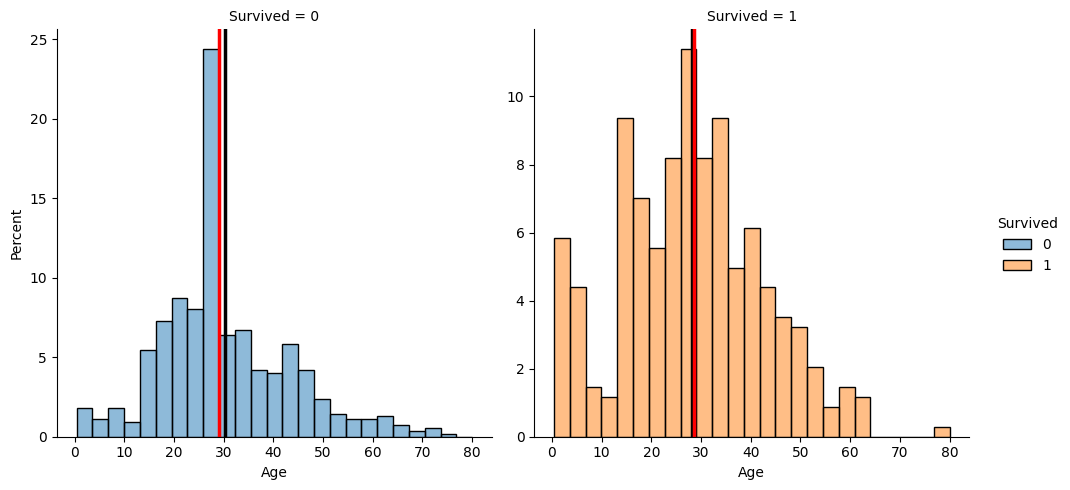

In [29]:
'''x = "Age"
g = sns.displot(data = df, 
                x = x_var, 
                hue = "Survived",
                col = "Survived", 
                facet_kws = dict(sharey = False, sharex = False))

for (row, col, hue_idx), data in g.facet_data():
    df_mean = df[x_var].mean()
    df_median = df[x_var].median()
    ax = g.facet_axis(row, col)
    ax.axvline(df_mean, c = "black", ls = "-", lw = 2.5)
    ax.text(df_mean, 0.99, f"mean: {df_mean:.2n}", color = "black",  ha = "left", va = "top", rotation = 90, transform = ax.get_xaxis_transform())
    ax.axvline(df_median, c = "r", ls = "--", lw = 2.5)
    
p = sns.histplot(data=data, x='age', stat='percent', hue='sex', common_norm=False)'''
#https://stackoverflow.com/questions/67613774/how-to-add-a-mean-and-median-line-to-a-seaborn-displot
df_agg_group = train_df.groupby("Survived").Age.agg(["mean", "median"])

g = sns.displot(data = train_df, 
                x = "Age", 
                col = "Survived", 
                stat = "percent",
                hue = "Survived",
                common_norm = False,
                facet_kws = dict(sharey = False, sharex = False))

axes = g.axes.flatten()
for ax in axes:
    spec = float(ax.get_title().split(" = ")[1])
    data = df_agg_group.loc[spec]
    mean_data = data["mean"]
    median_data = data["median"]
    ax.axvline(x = mean_data, c = "k", ls = "-", lw = 2.5)
    #ax.text(x = mean_data, 0.99, f"mean: {mean_data}", color = "r",  ha = "right", va = "top", rotation = 90, transform = ax.get_xaxis_transform())
    ax.axvline(x = median_data, c = "r", ls = "-", lw = 2.5)
    #ax.text(x = median_data, 0.99, f"median: {median_data}", color = "r",  ha = "right", va = "top", rotation = 90, transform = ax.get_xaxis_transform())

**Survival Rate by Age**

Survival rate of children/adolescents at 58% and 48% respectively. This again corresponds to the old social norm that children (along with women) would be saved first. Other adults had similar survival rates of around 35 - 43% except for those above the age of 59. This may be due to physical/health limitations of these more elderly individuals.

In [30]:
# Age Bins of Size 10
bins_by_10 = [0, 9, 19, 29, 39, 49, 59, 99] 
# Age Bins by Life Stages
bins_by_age_group = [0, 12, 17, 25, 44, 59, 99]

# Bins of size 10 corresponding to older passengers (i.e., 59 - 68, 69 - 78, 79 - 88) have low counts and have been combined as one bin.
for data in datasets:
    data["AgeByBins"] = pd.cut(x = data["Age"], 
                           bins = bins_by_10)
    data["AgeByLifestage"] = pd.cut(x = data["Age"], 
                                 bins = bins_by_age_group, 
                                 labels = ("Children", "Adolescent", "Young Adult", "Adult", "Middle Age", "Old Age"))

train_df.groupby(["AgeByBins"]).agg(total_passengers = ("PassengerId", "count"), 
                                total_survived = ("Survived", "sum"),
                                survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
AgeByBins,,,
"(0, 9]",66,40,0.606061
"(9, 19]",135,60,0.444444
"(19, 29]",312,86,0.275641
"(29, 39]",186,82,0.440860
"(39, 49]",117,47,0.401709
"(49, 59]",49,20,0.408163
"(59, 99]",26,7,0.269231


In [31]:
train_df.groupby(["AgeByLifestage"]).agg(total_passengers = ("PassengerId", "count"), 
                                      total_survived = ("Survived", "sum"),
                                      survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
AgeByLifestage,,,
Children,73,42,0.575342
Adolescent,77,40,0.519481
Young Adult,190,65,0.342105
Adult,435,152,0.349425
Middle Age,90,36,0.400000
Old Age,26,7,0.269231


### 1.4.4 SibSp + Par

Instead of using each of these features separately, we will combine these two features into the total feature (Total Family Members). By being in a family group, this can affect the survival probability of each passenger.

**Survival Rate by Total Family Members**

There is a higher probability of survival when a passenger has 1 - 3 family members (55 - 72%), but lower if a passenger has 0 family members or more than 3 family members. When a passenger has relatives on board, they are more likely to help each other survive but when there are too many relatives, then this can slow down their progress on getting to the deck and thus, can impede their survival chances. If a passenger is alone, they are less likely to survive than when another passenger who has a few relatives.

In [32]:
# Total relatives of a passenger
# It sums the number of siblings/spouses and the number of parents/children 
for data in datasets:
    data["RelativesCount"] = data["SibSp"] + data["Parch"]

train_df.groupby(["RelativesCount"]).agg(total_passengers = ("PassengerId", "count"), 
                                      total_survived = ("Survived", "sum"),
                                      survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
RelativesCount,,,
0,537,163,0.303538
1,161,89,0.552795
2,102,59,0.578431
3,29,21,0.724138
4,15,3,0.200000
5,22,3,0.136364
6,12,4,0.333333
7,6,0,0.000000
10,7,0,0.000000


In [33]:
# Groups by no. of relatives
# "Alone" (0 relatives), "Small" (1 - 3 relatives) and "Large" (> 3 relatives)
# (The pivot table of the Survival Rate by No. of Family Members showed that each group had 
# distinct survival rates)
for data in datasets:
    conditions = [(data["RelativesCount"] == 0), 
                  (data["RelativesCount"] <= 3) & (data["RelativesCount"] >= 1),
                  (data["RelativesCount"] > 3)
                 ]
    values = ["Alone", "Small", "Large"]
    data["FamilySize"] = np.select(conditions, values)
    

train_df.groupby(["FamilySize"]).agg(total_passengers = ("PassengerId", "count"), 
                                   total_survived = ("Survived", "sum"),
                                   survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
FamilySize,,,
Alone,537,163,0.303538
Large,62,10,0.161290
Small,292,169,0.578767


### 1.4.5 Ticket

Looking at the tickets will allow us to determine if the passenger was travelling with people outside of their family. We will use the relevant feature counting the number of people travelling with the specific feature.

Some passengers share the same ticket despite not sharing the same family name or having any related family members. This implies that they were travelling as a group and thus, could act similarly to that of a family group.

When looking at the survival rate, it does reflect similarly to that of a family group. When an individual travels in a group such as 2 - 5, the survival rate is higher than that of travelling alone. However, once a group becomes too big, the survival rate is lower than travelling solo. This is probably because a travelling group will try wait for each other and help each other survive but when it is too large, it will slow down their progress or impede their ability on getting on a lifeboat (if they want to leave on a lifeboat together)


In [34]:
train_df.groupby("Ticket").agg(TravellingGroup = ("PassengerId", "count")).sort_values(by = "TravellingGroup", ascending = False)

,TravellingGroup
Ticket,
1601,7
CA. 2343,7
347082,7
CA 2144,6
347088,6
...,...
345572,1
345364,1
343276,1


In [35]:
for data in datasets:
    grouped_tickets = data.groupby("Ticket").agg(TravellingGroup = ("PassengerId", "count"))
    dtmp = data.merge(grouped_tickets, how = "left", on = "Ticket")
    data["TravellingGroup"] = dtmp["TravellingGroup"]

In [36]:
train_df.groupby(["TravellingGroup"]).agg(total_passengers = ("PassengerId", "count"), 
                                   total_survived = ("Survived", "sum"),
                                   survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
TravellingGroup,,,
1,547,163,0.297989
2,188,108,0.574468
3,63,44,0.698413
4,44,22,0.500000
5,10,0,0.000000
6,18,0,0.000000
7,21,5,0.238095


In [37]:
#Groups travelling group by size
for data in datasets:
    conditions = [(data["TravellingGroup"] == 1), 
                  (data["TravellingGroup"] <= 4) & (data["TravellingGroup"] >= 2),
                  (data["TravellingGroup"] > 4)
                 ]
    values = ["Alone", "Small", "Large"]
    data["TravellingGroupSize"] = np.select(conditions, values)

train_df.groupby(["TravellingGroupSize"]).agg(total_passengers = ("PassengerId", "count"), 
                                   total_survived = ("Survived", "sum"),
                                   survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
TravellingGroupSize,,,
Alone,547,163,0.297989
Large,49,5,0.102041
Small,295,174,0.589831


### 1.3.6 Fare

This could potentially be a useful predictor for the survival of a passenger.

For different fares, there are distinct survival rates. For example, passengers that paid $100 - 150 had a survival rate of 79%, which is significantly higher than other fare groups. They are a subset of the 1st passenger class. Thus, this may provide additional information about the survival rate beyond the passenger class.

In [38]:
# Fare Bins of Size 50
bins_by_50 = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] 

for data in datasets:
    data["FareByBins"] = pd.cut(x = data["Fare"], 
                           bins = bins_by_50)
    
train_df.groupby(["FareByBins"]).agg(total_passengers = ("PassengerId", "count"), 
                                total_survived = ("Survived", "sum"),
                                survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
FareByBins,,,
"(0, 50]",716,232,0.324022
"(50, 100]",107,70,0.654206
"(100, 150]",24,19,0.791667
"(150, 200]",9,6,0.666667
"(200, 250]",11,7,0.636364
"(250, 300]",6,4,0.666667
"(300, 350]",0,0,NaN
"(350, 400]",0,0,NaN
"(400, 450]",0,0,NaN


In [39]:
#All the fares between $100 and $150 are 1st class passengers.
train_df[(train_df["Fare"] <= 150) & (train_df["Fare"] > 100)].groupby(["Pclass"]).agg(total_passengers = ("PassengerId", "count"))

,total_passengers
Pclass,
1,24


### 1.3.7 Cabin

Instead of using the cabin data, we will instead extract the deck letter and use that as a feature.

**Survival Rate by Deck**
![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/402px-Titanic_cutaway_diagram.png)

Each deck has different survival rates. 

Decks B, D, E have the highest survival rates. This is most likely because these decks were closer to the Boat Deck, which had access to the lifeboats. They are occupied mainly by 1st class passengers. Meanwhile, second class passengers mainly had cabins on D, E, F, G decks and most third class cabins were located on F deck and G deck, which were on the lowest decks and this would mean more difficult access to the life boats. Deck M has the lowest survival rate, which can be explained by the missing decks being primarily occupied by 2nd and 3rd class passengers. With less passengers surviving, it is possible that cabin data for those passengers were not able to be retrieved.

Despite having mainly first class passengers, Deck A and C have relatively lower survival rates. This could be because of other factors such as the possibility that those passengers were exploring other deck levels besides their sleeping deck during the accident.


In [40]:
train_df.groupby(["Deck"]).agg(total_passengers = ("PassengerId", "count"), 
                         total_survived = ("Survived", "sum"),
                         survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
Deck,,,
A,16,7,0.437500
B,47,35,0.744681
C,59,35,0.593220
D,33,25,0.757576
E,32,24,0.750000
F,13,8,0.615385
G,4,2,0.500000
M,687,206,0.299854


**Proportion of PClass by Deck**

<Axes: xlabel='Deck'>

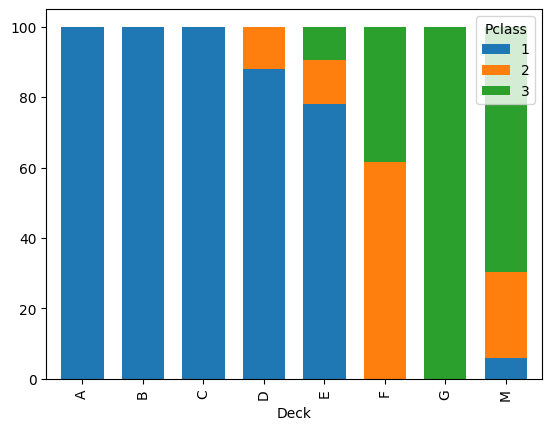

In [41]:
deck_pclass_df = train_df.groupby(["Deck", "Pclass"]).size().unstack().fillna(0)
deck_pclass_df_perc = deck_pclass_df.div(deck_pclass_df.sum(axis = 1), axis = 0) * 100
deck_pclass_df_perc.plot(kind='bar', stacked=True, width = 0.7)

### 1.3.8 Embarked

We will use Embarked as a feature.

**Survival Rate by Embarked**

In [42]:
train_df.groupby(["Embarked"]).agg(total_passengers = ("PassengerId", "count"), 
                         total_survived = ("Survived", "sum"),
                         survival_rate = ("Survived", "mean"))

,total_passengers,total_survived,survival_rate
Embarked,,,
C,168,93,0.553571
Q,77,30,0.389610
S,646,219,0.339009


Because females have a distinctly higher survival rate than males, we will further segment survival rate by not only the port the passenger embarks on but also the gender.

Both females and males have the highest survival rate when they embark from Port C. Following that, females would have a higher survival chance if they embark from Port Q then S, while males would have a higher survival chance if they embark from Port S then Port Q.

In [43]:
train_df.groupby(["Embarked", "Sex"]).agg(total_passengers = ("PassengerId", "count"), 
                         total_survived = ("Survived", "sum"),
                         survival_rate = ("Survived", "mean"))

total_passengers  total_survived  survival_rate
Embarked Sex                                                    
C        female                73              64       0.876712
         male                  95              29       0.305263
Q        female                36              27       0.750000
         male                  41               3       0.073171
S        female               205             142       0.692683
         male                 441              77       0.174603

# 2.1 Modelling

Combining the training and test data sets to apply one hot encoding.

In [44]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Title,Deck,AgeByBins,AgeByLifestage,RelativesCount,FamilySize,TravellingGroup,TravellingGroupSize,FareByBins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,Mr,M,"(19, 29]",Young Adult,1,Small,1,Alone,"(0, 50]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,Mrs,C,"(29, 39]",Adult,1,Small,1,Alone,"(50, 100]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,Ms,M,"(19, 29]",Adult,0,Alone,1,Alone,"(0, 50]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,Mrs,C,"(29, 39]",Adult,1,Small,2,Small,"(50, 100]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,Mr,M,"(29, 39]",Adult,0,Alone,1,Alone,"(0, 50]"


In [45]:
columns_to_drop = ["Name", "SibSp", "Parch", "Ticket", "Cabin", "AgeByBins", "AgeByLifestage", "RelativesCount", "TravellingGroup", "FareByBins"]
train_df_model = train_df.drop(columns = columns_to_drop)
test_df_model = test_df.drop(columns = columns_to_drop)
train_df_model.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Deck,FamilySize,TravellingGroupSize
0,1,0,3,male,22.0,7.2500,S,Mr,M,Small,Alone
1,2,1,1,female,38.0,71.2833,C,Mrs,C,Small,Alone
2,3,1,3,female,26.0,7.9250,S,Ms,M,Alone,Alone
3,4,1,1,female,35.0,53.1000,S,Mrs,C,Small,Small
4,5,0,3,male,35.0,8.0500,S,Mr,M,Alone,Alone


In [46]:
#Applying one hot encoding to categorical data for both the train data and test data 
cat_cols = ["Pclass", "Sex", "Embarked", "Title", "Deck", "FamilySize", "TravellingGroupSize"]

train_df_model_enc = pd.get_dummies(train_df_model, columns = cat_cols)
test_df_model_enc = pd.get_dummies(test_df_model, columns = cat_cols)
#Training data (and cross validation data)
X = train_df_model_enc.drop(columns = ["PassengerId", "Survived"])
y = train_df_model_enc["Survived"]
#Test data
X_test_final = test_df_model_enc
X.head()


,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Deck_E,Deck_F,Deck_G,Deck_M,FamilySize_Alone,FamilySize_Large,FamilySize_Small,TravellingGroupSize_Alone,TravellingGroupSize_Large,TravellingGroupSize_Small
0,22.0,7.2500,False,False,True,False,True,False,False,True,...,False,False,False,True,False,False,True,True,False,False
1,38.0,71.2833,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,True,True,False,False
2,26.0,7.9250,False,False,True,True,False,False,False,True,...,False,False,False,True,True,False,False,True,False,False
3,35.0,53.1000,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,True
4,35.0,8.0500,False,False,True,False,True,False,False,True,...,False,False,False,True,True,False,False,True,False,False


Standardising the scales of features is not necessary for random forest classifiers so this is omitted. Furthermore, tree-based models are not affected by the dummy variable trap/multicollinearity as it selects different sets of features for each model, so we will not be dropping one category per feature.

The high correlation mainly belongs within the various categories in each feature.

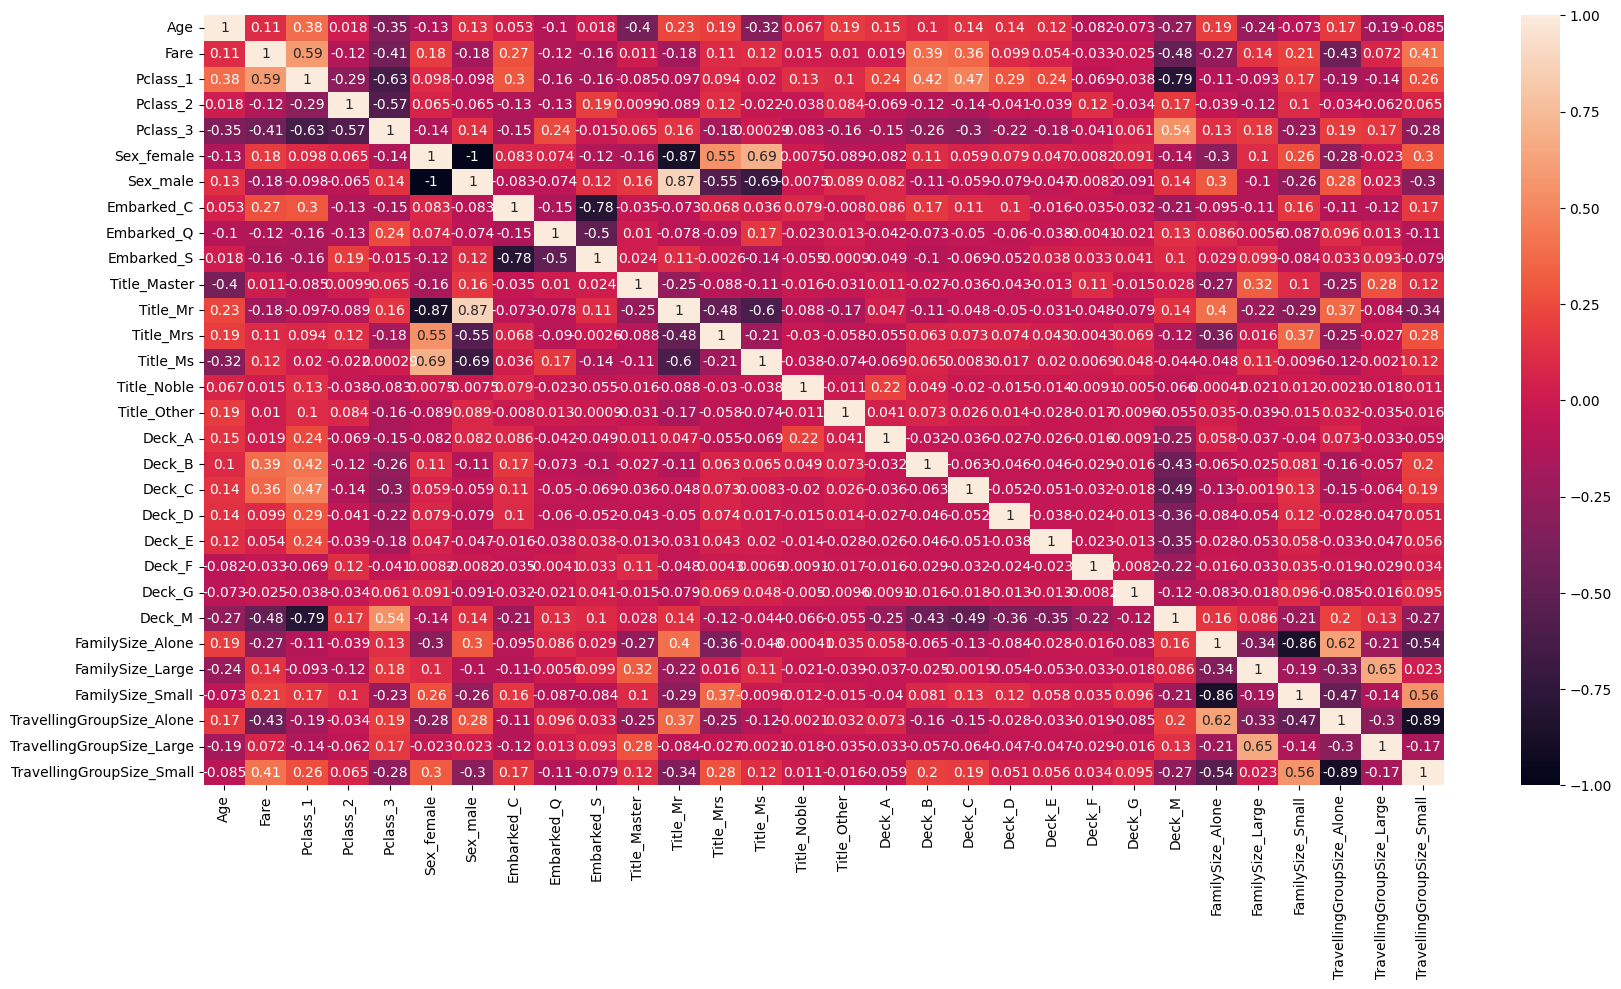

In [47]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(X.corr(), annot = True)
plt.show()

In [48]:
#Split data into train and test data
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Instantiate random forest classifier
clf = RandomForestClassifier(random_state = 42)

#Train on default hyperparameters
clf.fit(X_train, y_train.values.ravel()) 
y_pred = clf.predict(X_test) 
print(classification_report(y_pred, y_test)) 

(891, 30)
(891,)
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       107
           1       0.74      0.76      0.75        72

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



Text(0, 0.5, 'Features')

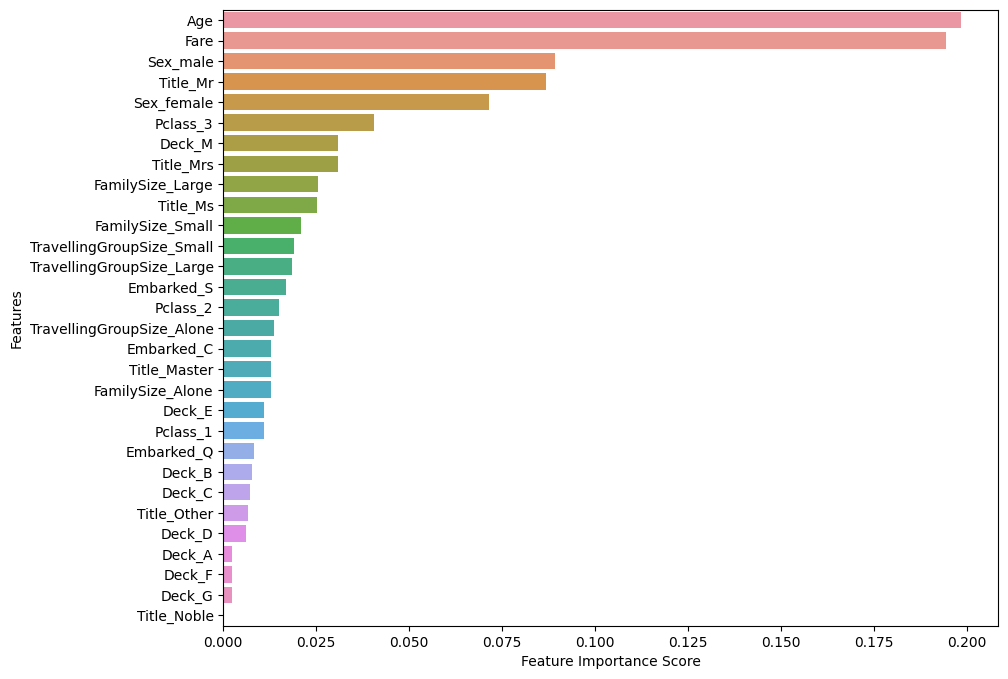

In [49]:
feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending = False)
plt.figure(figsize = (10, 8))
sns.barplot(x = feature_importance, y = feature_importance.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
#Maximum number of levels in each tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

#Define a grid of hyperparameter parameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [51]:
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100,  n_jobs = -1, cv = 5, random_state = 42)
clf_random.fit(X_train, y_train.values.ravel())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

F1 score after optimising hyperparameters using Random Search CV has increased.

In [52]:
print(clf_random.best_params_)
print(clf_random.best_score_)
best_clf = clf_random.best_estimator_
y_pred_clf = best_clf.predict(X_test)
print(classification_report(y_pred_clf, y_test)) 

{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
0.8356446370530877
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       109
           1       0.78      0.83      0.81        70

    accuracy                           0.84       179
   macro avg       0.83      0.84      0.84       179
weighted avg       0.85      0.84      0.84       179



Text(0, 0.5, 'Features')

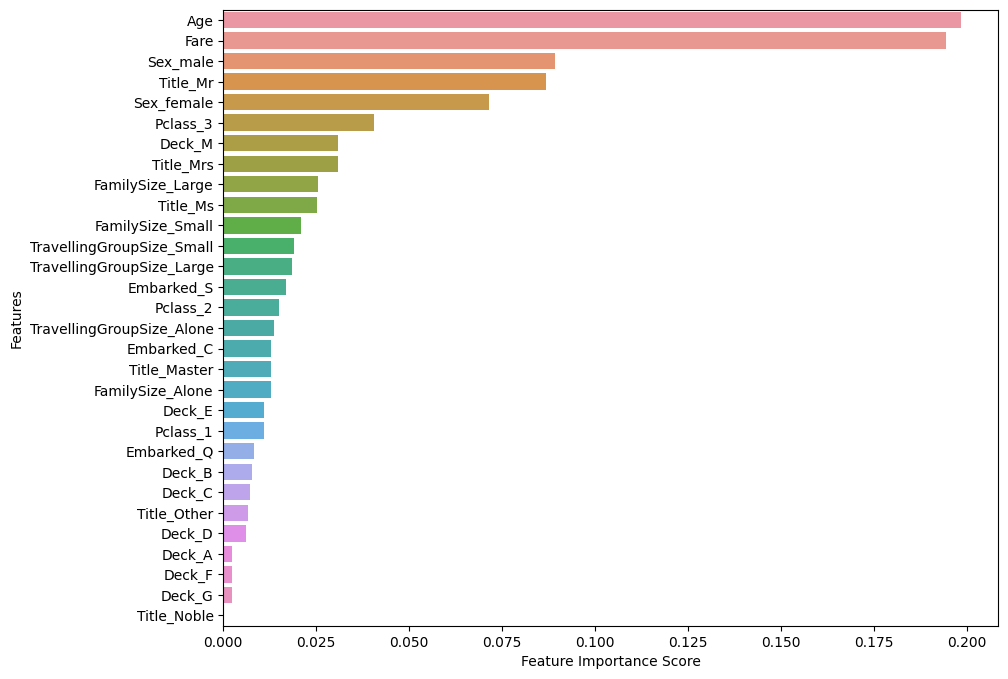

In [53]:
feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending = False)
plt.figure(figsize = (10, 8))
sns.barplot(x = feature_importance, y = feature_importance.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")

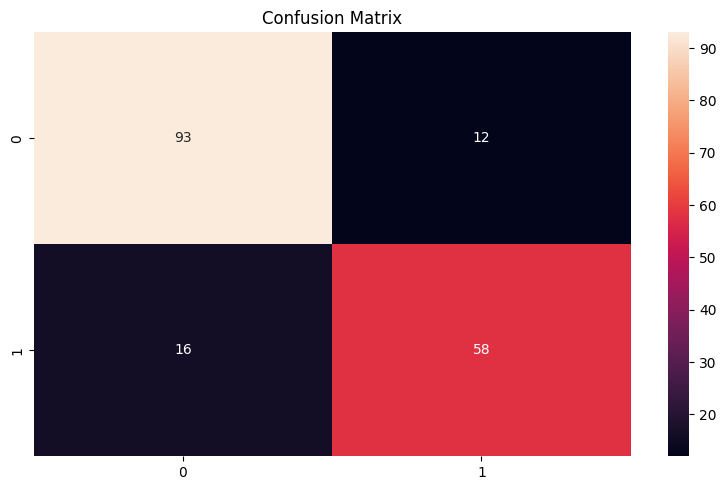

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred_clf)

plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.tight_layout()

Predicting on the actual test data and exporting to csv file.

In [55]:
'''
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3, 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [600, 700, 800]
}

# Instantiate the grid search model
clf_grid_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1)
clf_grid_cv.fit(X_train, y_train.values.ravel())
print(clf_grid_cv.best_params_)
print(clf_grid_cv.best_score_)
best_clf_grid_cv = clf_grid_cv.best_estimator_
y_pred_clf_grid_cv = best_clf_grid_cv.predict(X_test)
print(classification_report(y_pred_clf_grid_cv, y_test)) 
'''

"\n# Create the parameter grid based on the results of random search \nparam_grid = {\n    'bootstrap': [True],\n    'max_depth': [90, 100, 110],\n    'max_features': [2, 3, 'sqrt'],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [2, 4, 6],\n    'n_estimators': [600, 700, 800]\n}\n\n# Instantiate the grid search model\nclf_grid_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1)\nclf_grid_cv.fit(X_train, y_train.values.ravel())\nprint(clf_grid_cv.best_params_)\nprint(clf_grid_cv.best_score_)\nbest_clf_grid_cv = clf_grid_cv.best_estimator_\ny_pred_clf_grid_cv = best_clf_grid_cv.predict(X_test)\nprint(classification_report(y_pred_clf_grid_cv, y_test)) \n"

In [56]:
predictions = best_clf.predict(X_test_final.drop(columns = ["PassengerId"]))
output = pd.DataFrame({"PassengerId": X_test_final["PassengerId"], 
                       "Survived": predictions})
output.to_csv('submission.csv', index = False)